In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from mobilenet_v3 import MobileNetV3Small
import cv2
from matplotlib import pyplot as plt

In [2]:
Dir = "../AntiDeepNude/nude_sexy_safe_v1_x320/testing"
cat = ["nude", "safe"]
data = []
for categories in cat:
    folder = os.path.join(Dir, categories)
    label = cat.index(categories)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = img_to_array(load_img(img_path, target_size=(224, 224)))
        data.append([img_arr, label])
        
X = []
Y = []
for features , labels in data:
    X.append(features)
    Y.append(labels)
X_test = np.array(X)/255
y_test = np.array(Y)

In [3]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [5]:
baseModel = MobileNetV3Small(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# baseModel = EfficientNetB7(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))


In [6]:
baseModel.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 112, 112, 16) 0           Conv/BatchNorm[0][0]             
___________________________________________________________________________________

In [103]:
x=baseModel.output
x=GlobalAveragePooling2D()(x)
# x=Dropout(0.5)(x)
x=Dense(256,activation='relu', )(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.3)(x)
# x=Dense(256,activation='relu')(x) #dense layer 2
x=Dense(128,activation='relu', )(x) #dense layer 3
preds=Dense(1,activation='sigmoid', kernel_regularizer="L2")(x) #final layer with softmax activation

In [104]:
model=Model(inputs=baseModel.input,outputs=preds)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 112, 112, 16) 0           Conv/BatchNorm[0][0]             
___________________________________________________________________________________________

In [105]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 Conv
2 Conv/BatchNorm
3 tf.__operators__.add
4 re_lu
5 tf.math.multiply
6 multiply
7 expanded_conv/depthwise/pad
8 expanded_conv/depthwise/DConv
9 expanded_conv/depthwise/BatchNorm
10 re_lu_1
11 expanded_conv/squeeze_excite/AvgPool
12 reshape
13 expanded_conv/squeeze_excite/Conv
14 expanded_conv/squeeze_excite/Relu
15 expanded_conv/squeeze_excite/Conv_1
16 tf.__operators__.add_1
17 re_lu_2
18 tf.math.multiply_1
19 expanded_conv/squeeze_excite/Mul
20 expanded_conv/project
21 expanded_conv/project/BatchNorm
22 expanded_conv_1/expand
23 expanded_conv_1/expand/BatchNorm
24 re_lu_3
25 expanded_conv_1/depthwise/pad
26 expanded_conv_1/depthwise/DConv
27 expanded_conv_1/depthwise/BatchNorm
28 re_lu_4
29 expanded_conv_1/project
30 expanded_conv_1/project/BatchNorm
31 expanded_conv_2/expand
32 expanded_conv_2/expand/BatchNorm
33 re_lu_5
34 expanded_conv_2/depthwise/DConv
35 expanded_conv_2/depthwise/BatchNorm
36 re_lu_6
37 expanded_conv_2/project
38 expanded_conv_2/project/BatchNorm


In [3]:
model = tf.keras.models.load_model('./mobilenetv3_train_9129_val_9023.h5')

In [14]:
# freeze model layers
for layer in model.layers[:100]:
    layer.trainable=False
for layer in model.layers[100:]:
    layer.trainable=True

In [15]:
TRAINING_DIR = "/home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
)

VALIDATION_DIR = "/home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='binary',
    batch_size=1024
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='binary',
    batch_size=1024
)

Found 628270 images belonging to 2 classes.
Found 8219 images belonging to 2 classes.


In [16]:
filepath = "./backup/over90_new_reduced_lastcheckpoint_{epoch:02d}.h5"
epochs = 2
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=100)
eStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=0,
    mode="auto",
)

In [17]:
def evaluate_val_set(batch, n):
    if batch % n == 0 and batch != 1 and batch != 0:
        loss, acc = model.evaluate(validation_generator, verbose=0)
        print(" - val_loss: ", loss, " - val_acc: ", acc)
        
from tensorflow.keras.callbacks import LambdaCallback
call = LambdaCallback(on_batch_end=lambda batch,logs: evaluate_val_set(batch, 30))

In [18]:
model.compile(loss = 'binary_crossentropy', optimizer=Adam(lr=0.01, decay=0.01/epochs), metrics=['accuracy'])

history = model.fit(train_generator, epochs=epochs, validation_data = validation_generator, verbose = 1, callbacks=[checkpoint, call, eStop])

Epoch 1/2
 14/614 [..............................] - ETA: 2:13:09 - loss: 0.1625 - accuracy: 0.9360

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/614 [===>..........................] - ETA: 1:59:49 - loss: 0.1979 - accuracy: 0.9245
Epoch 00001: saving model to ./backup/over90_new_reduced_lastcheckpoint_01.h5
104/614 [====>.........................] - ETA: 1:58:42 - loss: 0.1981 - accuracy: 0.9245

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/PIL/Image.py:2858: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


200/614 [========>.....................] - ETA: 1:34:59 - loss: 0.2070 - accuracy: 0.9224
Epoch 00001: saving model to ./backup/over90_new_reduced_lastcheckpoint_01.h5
242/614 [==========>...................] - ETA: 1:25:31 - loss: 0.2075 - accuracy: 0.9223

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/PIL/Image.py:2858: DecompressionBombWarning: Image size (138012160 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


300/614 [=============>................] - ETA: 1:11:39 - loss: 0.2092 - accuracy: 0.9218
Epoch 00001: saving model to ./backup/over90_new_reduced_lastcheckpoint_01.h5
400/614 [==================>...........] - ETA: 48:48 - loss: 0.2158 - accuracy: 0.9195
Epoch 00001: saving model to ./backup/over90_new_reduced_lastcheckpoint_01.h5
500/614 [=======================>......] - ETA: 25:53 - loss: 0.2148 - accuracy: 0.9196
Epoch 00001: saving model to ./backup/over90_new_reduced_lastcheckpoint_01.h5
578/614 [===========================>..] - ETA: 8:10 - loss: 0.2125 - accuracy: 0.9201

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/PIL/Image.py:2858: DecompressionBombWarning: Image size (143872000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


600/614 [============================>.] - ETA: 3:10 - loss: 0.2115 - accuracy: 0.9204
Epoch 00001: saving model to ./backup/over90_new_reduced_lastcheckpoint_01.h5
614/614 [==============================] - 8406s 14s/step - loss: 0.2113 - accuracy: 0.9204 - val_loss: 0.2726 - val_accuracy: 0.8993
Epoch 2/2
 86/614 [===>..........................] - ETA: 1:56:37 - loss: 0.1900 - accuracy: 0.9269
Epoch 00002: saving model to ./backup/over90_new_reduced_lastcheckpoint_02.h5
186/614 [========>.....................] - ETA: 1:35:54 - loss: 0.1884 - accuracy: 0.9270
Epoch 00002: saving model to ./backup/over90_new_reduced_lastcheckpoint_02.h5
286/614 [============>.................] - ETA: 1:13:31 - loss: 0.1890 - accuracy: 0.9265
Epoch 00002: saving model to ./backup/over90_new_reduced_lastcheckpoint_02.h5
386/614 [=================>............] - ETA: 51:06 - loss: 0.1899 - accuracy: 0.9260
Epoch 00002: saving model to ./backup/over90_new_reduced_lastcheckpoint_02.h5
486/614 [============

In [19]:
model.save("mobilenetv3_train_8963_val_8764__newer.h5")

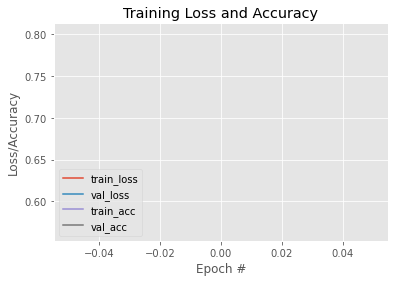

In [15]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# DATA CLEANSING

In [1]:
import os
import cv2
bad_list=[]
dir="/home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320"
subdir_list=os.listdir(dir) # create a list of the sub directories in the directory ie train or test
for d in subdir_list:  # iterate through the sub directories train and test
    dpath=os.path.join (dir, d) # create path to sub directory
    if d in ['training']:#, 'train']:
        class_list=os.listdir(dpath) # list of classes ie dog or cat
       # print (class_list)
        for klass in class_list: # iterate through the two classes
            class_path=os.path.join(dpath, klass) # path to class directory
            #print(class_path)
            file_list=os.listdir(class_path) # create list of files in class directory
            for f in file_list: # iterate through the files
                fpath=os.path.join (class_path,f)
                index=f.rfind('.') # find index of period infilename
                ext=f[index+1:] # get the files extension
                if ext  not in ['jpg', 'png', 'bmp', 'gif', 'jpeg']:
                    print(f'file {fpath}  has an invalid extension {ext}')
                    bad_list.append(fpath)                    
                else:
                    try:
                        img=cv2.imread(fpath)
                        size=img.shape
                    except:
                        print(f'file {fpath} is not a valid image file ')
                        bad_list.append(fpath)
                       
print (bad_list)
                    
    

file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_16089.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_9533.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_22076.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_7493.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_21277.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_26613.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_7370.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_16036.jpg is not a valid image file 
file /home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/training/safe/facebook_12820.jpg is n

In [2]:
len(bad_list)

26180

In [3]:
i=1
for bad in bad_list:
    print(i)
    os.remove(bad)
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [16]:
TEST_DIR = "/home/ubuntu/AntiDeepNude/nude_sexy_safe_v1_x320/testing"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(224,224),
	class_mode='binary',
    batch_size=1024
)
model.evaluate(test_generator)

Found 8147 images belonging to 2 classes.
8/8 [==============================] - 34s 4s/step - loss: 0.2251 - accuracy: 0.9076


[0.22511813044548035, 0.9075733423233032]

In [4]:
z = model.predict(X_test)
print(z.shape)


(8147, 1)


(8147,)

In [8]:
test_prediction = [(i > 0.5).astype(int) for i in z.ravel()]
# test_prediction.shape
test_prediction[:5]

[0, 0, 0, 0, 0]

1


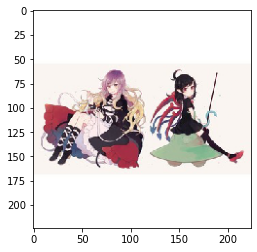

In [10]:
print(y_test[5555])
plt.imshow(X_test[5555])

In [9]:
print(classification_report(y_test, test_prediction, target_names=["nude", "safe"]))

              precision    recall  f1-score   support

        nude       0.90      0.92      0.91      4097
        safe       0.92      0.90      0.91      4050

    accuracy                           0.91      8147
   macro avg       0.91      0.91      0.91      8147
weighted avg       0.91      0.91      0.91      8147

